In [1]:
import numpy as np
import thinkdsp
import pyaudio
import thinkplot
import matplotlib.pyplot as plt
import audioop
import struct
from array import array
import wave as wv
from IPython.display import Audio
import pygame




%matplotlib inline

In [68]:
sample = 1.0/200 #samples per second to test against
pitch = 440
sig_type = 'sin'
filename =  'flesh_wound.wav'

In [3]:
def get_samples_from_mic(sample_rate = 8000, threshold = 1000, chunk_size = 1000):
    # initialize pyaudio object
    p = pyaudio.PyAudio()
    stream = p.open(format=pyaudio.paInt16, channels=1, rate=sample_rate,
            input=True, output=True,
            frames_per_buffer=chunk_size)

    
    def is_silent(snd_data, th):
    #"Returns 'True' if below the 'silent' threshold"
        return max(snd_data) < th


# initialize an array to store the data
    data_vec = array('h')
    
# wait until we hear something
    while 1:
        # read a chunk of samples from the mic
        data = stream.read(chunk_size)
        # convert the data into an array of int16s
        snd_data = array('h', data)
        # if no longer silent break out of detection loop
        if not is_silent(snd_data, threshold):
            break

# append the sound data from the previous chunk into the array             
    data_vec.extend(snd_data)
    
# collect samples until we get a silent block
    while 1:
        # read a chunk of data
        data = stream.read(chunk_size)
        snd_data = array('h', data)
        # stick the chunk of samples at the end of the vector that stores
        # the samples
        data_vec.extend(snd_data)     
        # if silent break out of loop
        if is_silent(snd_data, threshold):
            break
            
# convert to a numpy array   
# we don't use a numpy array directly because it's slower than
# array 
    x = np.frombuffer(data_vec, dtype= np.dtype('int16'))    
    
# close the pyaudio stream     
    stream.stop_stream()
    stream.close()
    p.terminate()

# return the data samples    
    return x  

In [4]:
chunk = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 41000
RECORD_SECONDS = 5

p = pyaudio.PyAudio()

stream = p.open(format = FORMAT,
                channels = CHANNELS,
                rate = RATE,
                input = True,
                output = True,
                frames_per_buffer = chunk)

print "* recording"

data = get_samples_from_mic(RATE,300,chunk)



* recording


In [5]:
DUR = len(data)/float(RATE)
audio = Audio(data=data, rate=RATE)
audio

In [6]:
DUR

1.5235121951219512

In [69]:
v_wave = thinkdsp.read_wave(filename)
print(v_wave.duration)
print(v_wave.framerate)
v_wave.normalize()
#wave.apodize()
v_wave.make_audio()

6.15328798186
11025


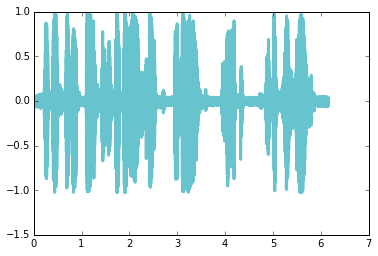

In [71]:
v_wave.plot()

In [72]:
vSeg = []
for s in np.arange(0,DUR,sample):
    start = round(s*RATE)
    stop = start + round(sample*RATE)
    vSeg.append(data[start: stop])

11025


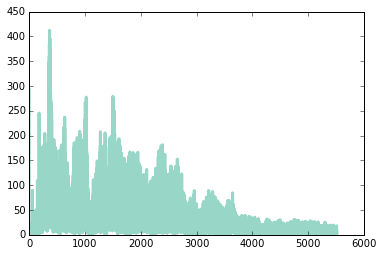

In [73]:

v_spectrum = v_wave.make_spectrum()
print(v_spectrum.framerate)
v_spectrum.plot()


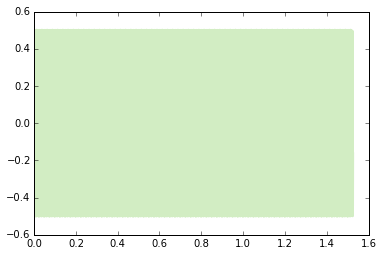

In [74]:
if sig_type == 'saw':
    sig = thinkdsp.SawtoothSignal(freq=pitch, amp=1, offset=0)
elif sig_type == 'sin':
    sig = thinkdsp.SinSignal(freq=pitch, amp=1, offset=0)
elif sig_type == 'cos':
    sig = thinkdsp.CosSignal(freq=pitch, amp=1, offset=0)
elif sig_type == 'tri':
    sig = thinkdsp.TriangleSignal(freq=pitch, amp=0.5, offset=0)
elif sig_type == 'sqr':
    sig = thinkdsp.SquareSignal(freq=pitch, amp=0.5, offset=0)
elif sig_type == 'par':
    sig = thinkdsp.ParabolicSignal(freq=pitch, amp=0.5, offset=0)
sig = thinkdsp.SawtoothSignal(freq=pitch, amp=0.5, offset=0)
wave=sig.make_wave(framerate = RATE, duration = DUR)
wave.plot()
wave.make_audio()

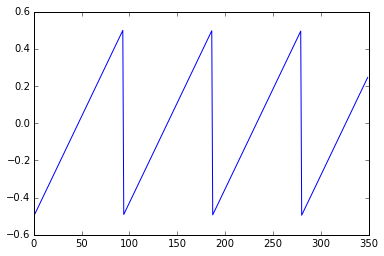

In [104]:
plt.plot(range(len(wave.ys[0:350])), wave.ys[0:350])

In [75]:
Seg = []
for s in np.arange(0,DUR,sample):
    Seg.append(wave.segment(s,sample))

41000


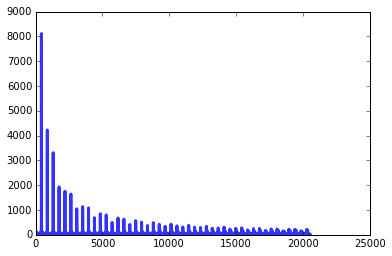

In [76]:
spec = wave.make_spectrum()
print(spec.framerate)
spec.plot()


In [124]:
#print(np.fft.fft(vSeg[0]))
#print(np.fft.fft(Seg[0].ys))
x = np.fft.fft(vSeg[100])
y = np.fft.fft(Seg[100].ys)
len(y)

205

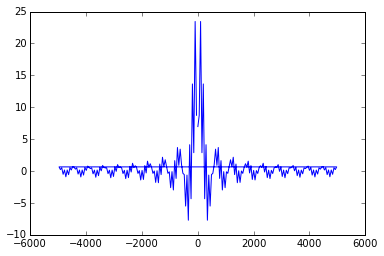

In [125]:
freq = np.fft.fftfreq(y.shape[-1])

plt.plot(freq*10000, -y)

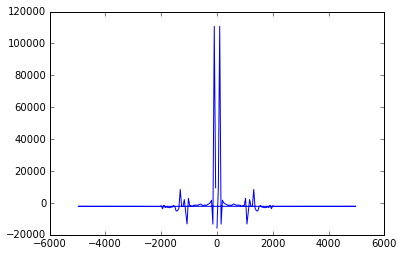

In [126]:
freq = np.fft.fftfreq(x.shape[-1])

plt.plot(freq*10000, -x.real)

In [130]:
frames= RATE
for i in range(len(vSeg)):
    x = np.fft.fft(vSeg[i])
    y = np.fft.fft(Seg[i].ys)
    hs =(np.absolute(x)*np.absolute(y))
    if i == 0:
        voc_s =(np.fft.ifft(hs))
        
    elif i==100 :
        v1 = hs
    else:
         voc_s = np.concatenate((voc_s, np.fft.ifft(hs)))
      
buf = np.zeros((len(voc_s), 2), dtype = np.int16)
    
for y in range(len(voc_s)):
    buf[y][0] = voc_s[y]
    buf[y][1] = voc_s[y]

c:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
c:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:18: ComplexWarning: Casting complex values to real discards the imaginary part


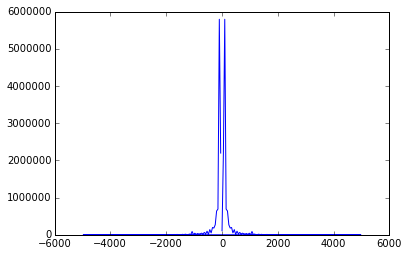

In [132]:

freq = np.fft.fftfreq(v1.shape[-1])

plt.plot(freq*10000, v1.real)

In [80]:
#voc_s.normalize()

dataout = np.array(voc_s*.05, dtype='int16') #undo the *2 that was done at reading
chunkout = struct.pack("%dh"%(len(dataout)), *list(dataout)) #convert back to 16-bit data
vcs = pygame.sndarray.make_sound(buf)
pygame.mixer.Sound(vcs).play()

print "done"
print ((voc_s))
print ('convert 1')
print dataout
print "convert 2"
D = len(chunkout)/float(RATE)

done
[-35892.43134736 -37006.13782036 -37930.46741328 ...,   -736.98963723
   -836.53959448   -798.70321682]
convert 1
[-1794 -1850 -1896 ...,   -36   -41   -39]
convert 2


array([[-22987, -22800, -22532, ...,   -736,   -836,   -798],
       [-22987, -22800, -22532, ...,   -736,   -836,   -798]], dtype=int16)